In [1]:
from ammgammalib import *
from rpathlib import *
from matplotlib import pyplot as plt
import numpy as np
print("AMMGammaLib version {0.__VERSION__} ({0.__DATE__})".format(AMMSim))
print("RPathLib version {0.__VERSION__} ({0.__DATE__})".format(RPath))

AMMGammaLib version 1.2 (26/Dec/2022)
RPathLib version 1.1 (26/Dec/2022)


In [2]:
STARTT = recordtime(init=True)

RECORDTIME -- Starting recording


# AMM Gamma vs Derivatives Gamma (Book 3--30DAYS)

## Analysis by fees

### Setup

In [3]:
PERIOD_MAX=202
PERIOD_STEP=5
TIME_DAYS = 30
PATH_N = 30000
SIGMA = 0.5
AMM_P0 = 100
AMM_TVL0 = 1000000
NUM_PATHS=100

FEEPC_R = [0.03, 0.02, 0.01, 0.005, 0.001, 0]

In [4]:
def run_analysis(feepc):
    PG = RPathGen(LOGNORM, sig=SIGMA, T=TIME_DAYS/365, N=PATH_N)
    sim0 = AMMSim(p0=AMM_P0, tvl0=AMM_TVL0, feepc=feepc)
    sims = {period:[] for period in range(1, PERIOD_MAX, PERIOD_STEP)}
    paths = PG.generate(NUM_PATHS)
    for p_ in paths:
        #print ("===NEW PATH===")
        for period in sims:
            sim = sim0.copy()
            #print("trades", sim.ntrades)
            p__=p_(period=period)
            for prc in p__.path():
                sim.trade_to(prc)
            sims[period] += [sim]

    sims_aggr = {
        period: sim0.aggregate(simlist)
        for period, simlist in sims.items()
    }
    return sims_aggr

### Simulation

In [5]:
SIMS_AGGR = dict()
for feepc in FEEPC_R:
    recordtime(f"Monte Carlo (fee={feepc*100}%)")
    SIMS_AGGR[feepc] = run_analysis(feepc=feepc)

RECORDTIME --  0.0s [Monte Carlo (fee=3.0%)]
RECORDTIME -- 36.2s [Monte Carlo (fee=2.0%)]
RECORDTIME -- 72.5s [Monte Carlo (fee=1.0%)]
RECORDTIME -- 108.8s [Monte Carlo (fee=0.5%)]
RECORDTIME -- 145.2s [Monte Carlo (fee=0.1%)]
RECORDTIME -- 181.7s [Monte Carlo (fee=0%)]


### Presentation

In [6]:
def pc_value_capture_plot(feepc):
    plt.plot(SIMS_AGGR[feepc].keys(), [sim.ammvalcapturepc for sim in SIMS_AGGR[feepc].values()], color="red", label="AMM LP value capture")
    plt.plot(SIMS_AGGR[feepc].keys(), [sim.arbvalcapturepc for sim in SIMS_AGGR[feepc].values()], color="blue", label="Arb value capture")
    plt.title(f"Perc value capture (fee={feepc*100}%, T={TIME_DAYS}d, vol={SIGMA*100}%)")
    plt.xlabel(f"rebalancing period length (N={PATH_N})")
    plt.ylim(0,1.1)
    plt.ylabel("ratio [1=100%]")
    plt.legend()
    plt.grid()
    plt.show()

def total_value_capture_plot(feepc):
    plt.plot(SIMS_AGGR[feepc].keys(), [sim.totalvalcapture/1000 for sim in SIMS_AGGR[feepc].values()], color="red")
    plt.title(f"Total value capture (T={TIME_DAYS}d, vol={SIGMA*100}%)")
    plt.xlabel(f"rebalancing period length (N={PATH_N})")
    plt.ylabel("Amount [USD '000]")
    plt.ylim(0,None)
    plt.grid()
    plt.show()

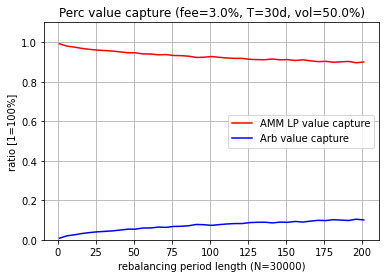

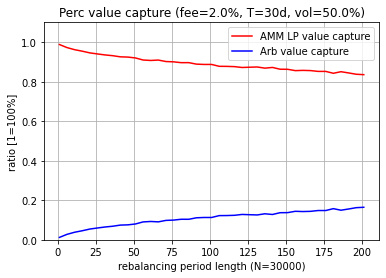

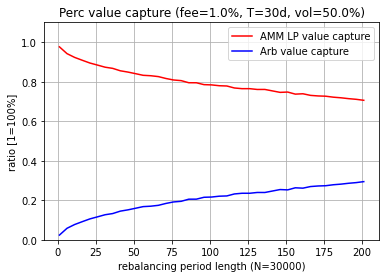

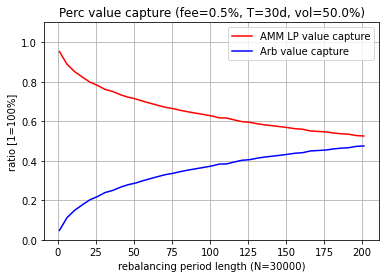

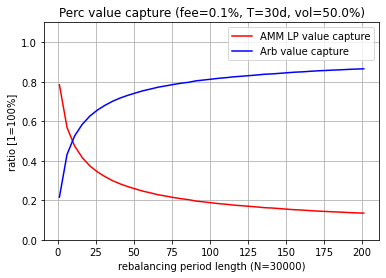

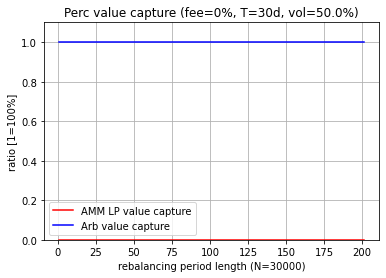

In [7]:
for feepc in FEEPC_R:
    pc_value_capture_plot(feepc)

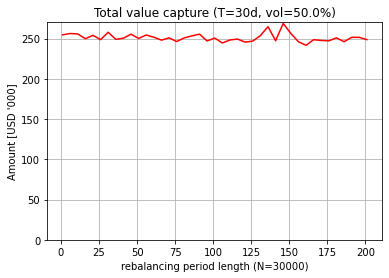

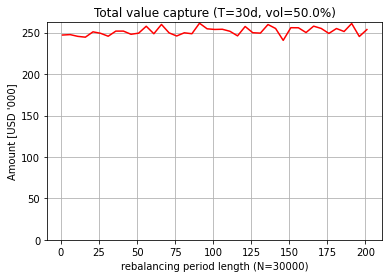

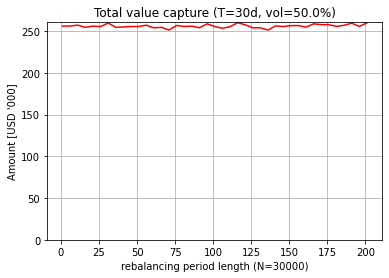

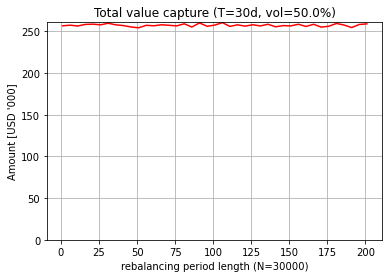

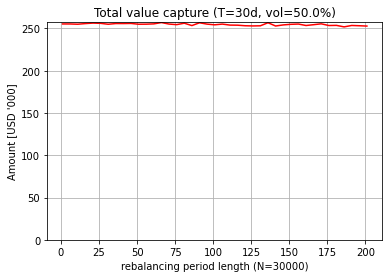

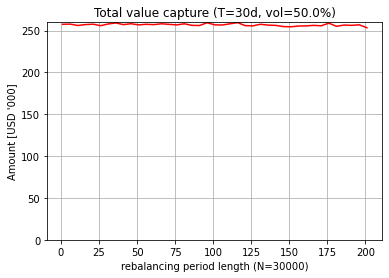

In [8]:
for feepc in FEEPC_R:
    total_value_capture_plot(feepc)

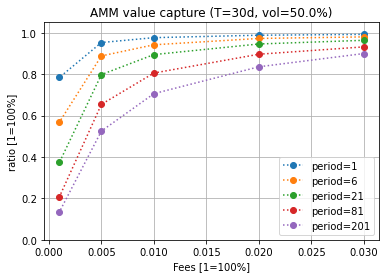

In [12]:
for period in [1, 6, 21, 81, 201]:
    plt.plot(FEEPC_R[:-1], [SIMS_AGGR[feepc][period].ammvalcapturepc for feepc in FEEPC_R[:-1]], 
             marker="o", linestyle="dotted", label=f"period={period}")
plt.title(f"AMM value capture (T={TIME_DAYS}d, vol={SIGMA*100}%)")
plt.xlabel(f"Fees [1=100%]")
plt.ylabel("ratio [1=100%]")
#plt.xscale("log")
plt.legend()
plt.ylim((0,1.05))
plt.grid()
plt.show()

## End

In [10]:
recordtime("Final")

RECORDTIME -- 219.8s [Final]


219.83099794387817